In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(4, 'h').delta

In [2]:
def get_vol(df):
    return np.sum( np.abs( np.diff(df.BTC.values) ) )

In [3]:
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [4]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.5, 's').delta

min_pos = 0.001

q0 = 10.0

In [5]:
gamma = 0.1

In [6]:
name = ['stoikov', 'future', 'furute aggresive', 'best price', 'future_linear']

In [7]:
s1 = StoikovStrategy(delay, min_pos, delay, gamma, 
                     theta_policy='spread')#базовая стратегия стоикова

s2 = FutureStrategy(delay, min_pos, delay, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='neutral', 
                    q0=q0)#стратегия с future_price, инвентарь не ликвидируем

s3 = FutureStrategy(delay, min_pos, delay, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='aggressive', 
                    q0=q0)#стратегия с future_price, ликвидируем инвентарь, как только выходим за пределы q_0

s4 = BaseStrategy(delay, min_pos, delay, 
                  inventory_policy='aggressive',
                  q0=q0)#best_price стратегия с ликвидацией при выходе за q_0

In [8]:
s5 = FutureStrategy(delay, min_pos, delay, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='linear', 
                    q0=q0)#стратегия с future_price, ликвидируем инвентарь, как только выходим за пределы q_0

In [9]:
strats = dict(zip(name, [s1, s2, s3, s4, s5]))

In [10]:
dfs = {}
for k, s in strats.items():
    r = s.run(Sim(md, latency, md_latency))
    
    dfs[k] = get_pnl(r['update'], cost=0.000001)
    del r

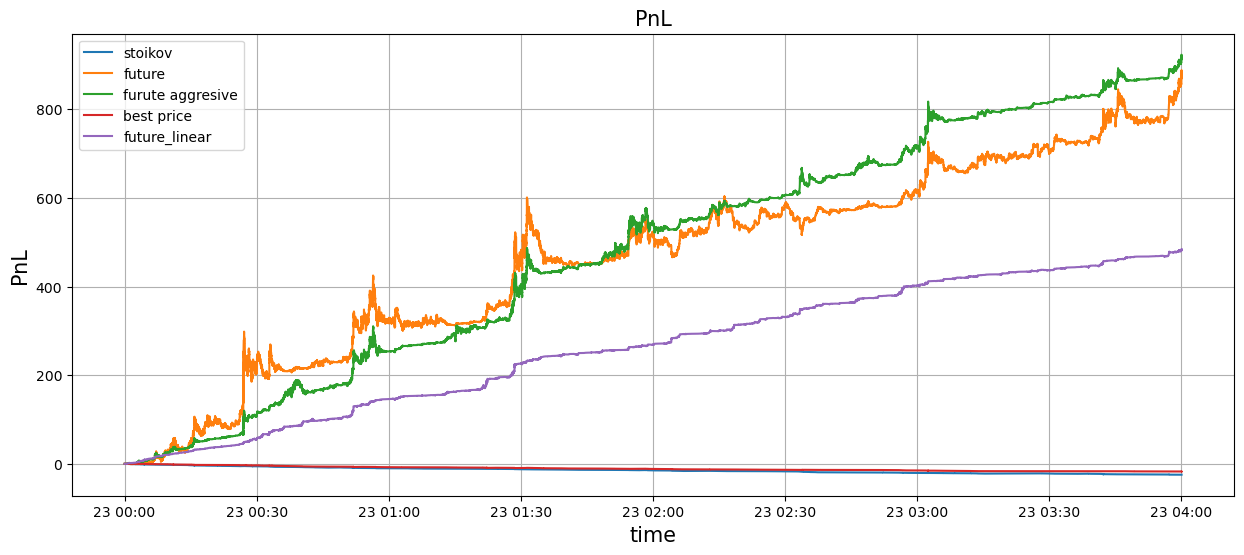

In [11]:
plt.figure(figsize=(15, 6))
for k, df in dfs.items():
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.total, label=k)
plt.legend()
plt.title("PnL", fontsize=15)
plt.xlabel('time', fontsize=15)
plt.ylabel('PnL', fontsize=15)
plt.grid()
plt.show()

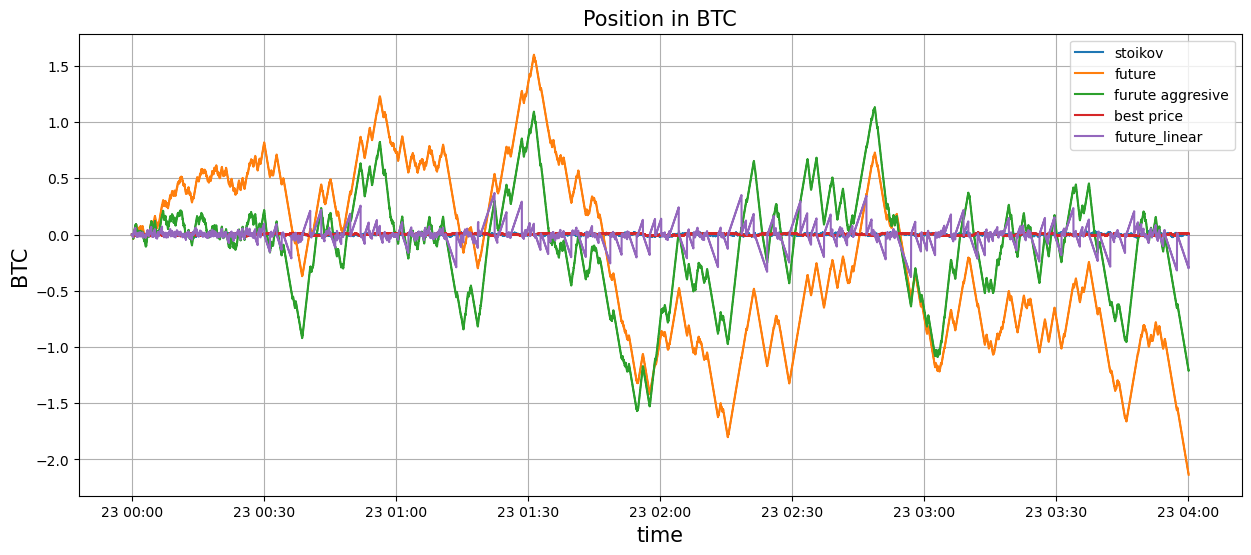

In [12]:
plt.figure(figsize=(15, 6))
for k, df in dfs.items():
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.BTC, label=k)
plt.legend()
plt.title("Position in BTC", fontsize=15)
plt.xlabel('time', fontsize=15)
plt.ylabel('BTC', fontsize=15)
plt.grid()
plt.show()

In [13]:
for k, df in dfs.items():
    vol = get_vol(df) / (T / 1e9 / 60)
    
    print(k, 'vol = ', round(vol, 5))

stoikov vol =  0.12828
future vol =  0.23053
furute aggresive vol =  0.27578
best price vol =  0.19233
future_linear vol =  0.23714


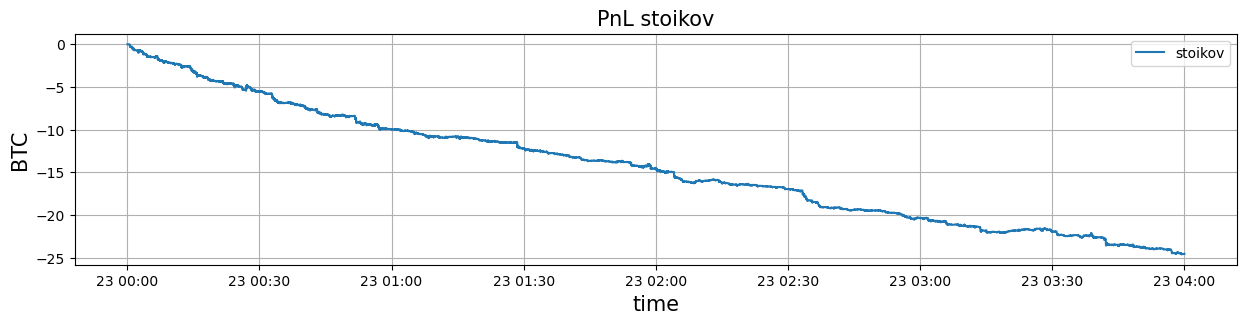

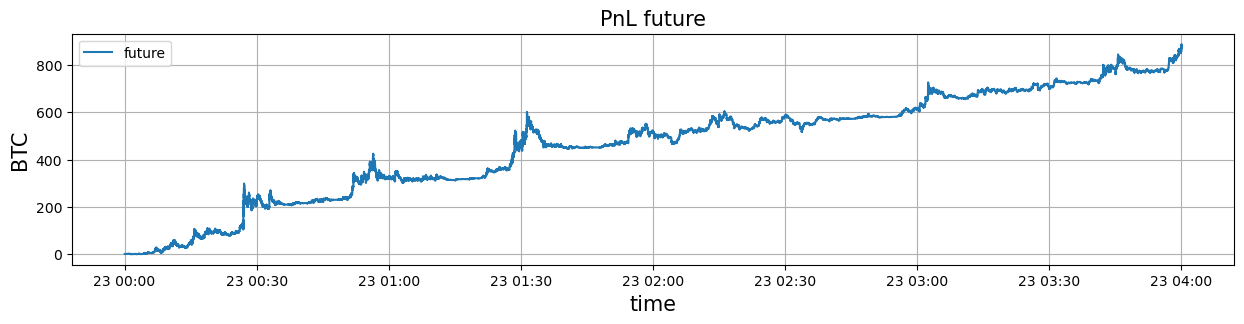

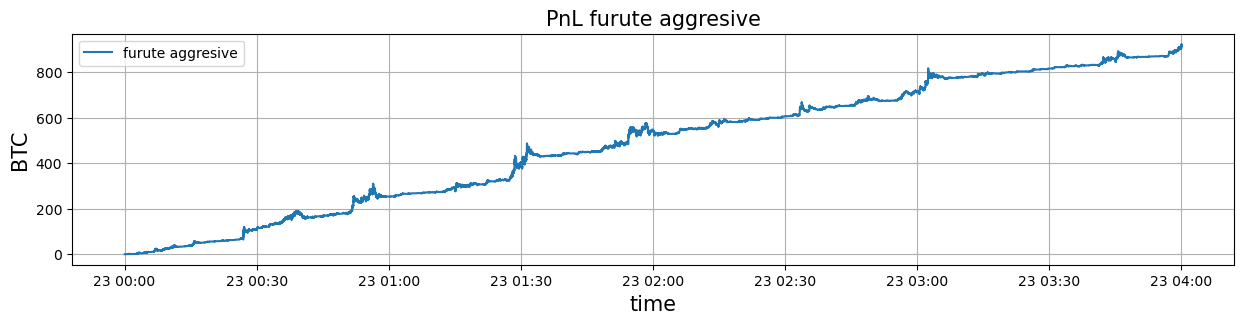

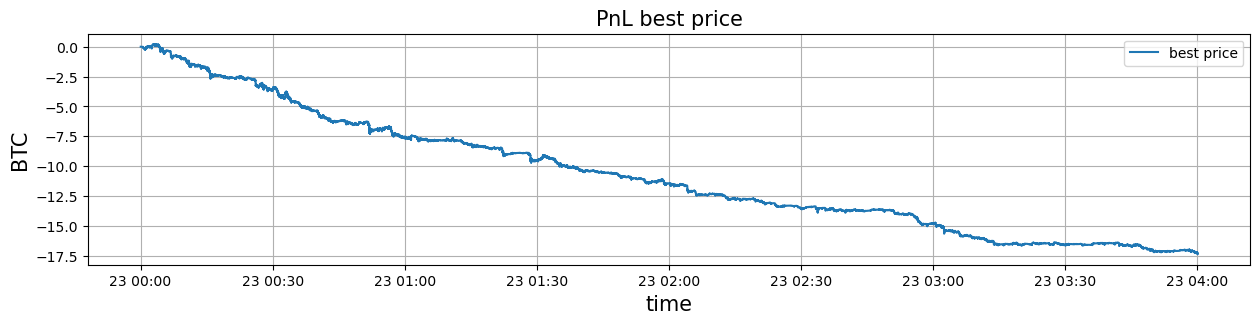

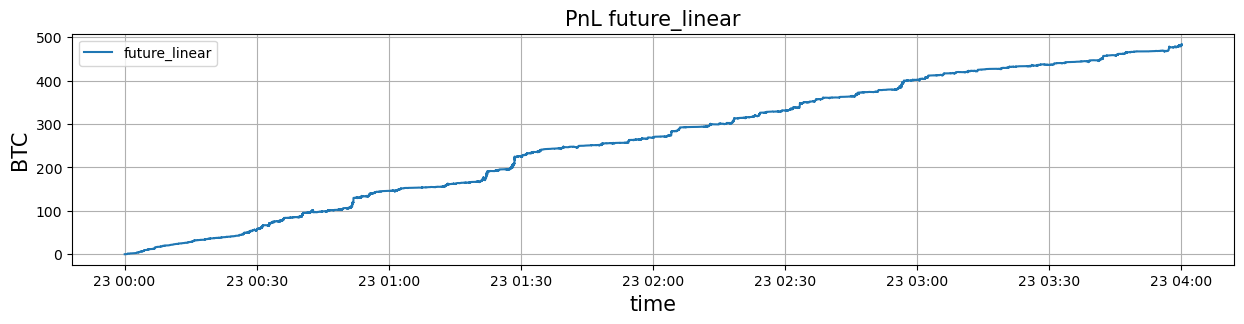

In [14]:
for k, df in dfs.items():
    plt.figure(figsize=(15, 3))
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.total, label=k)
    plt.legend()
    plt.title("PnL " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

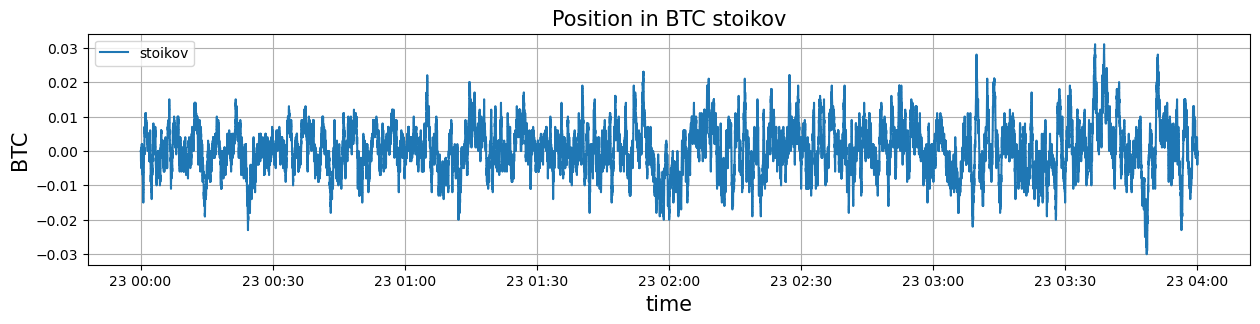

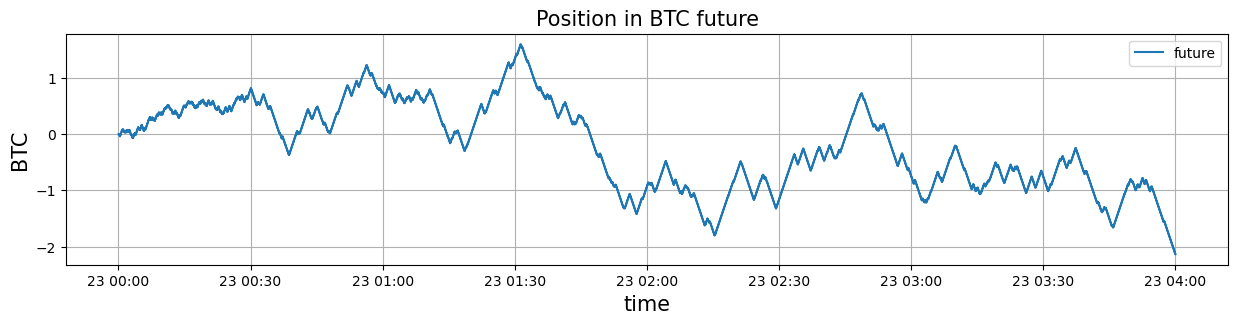

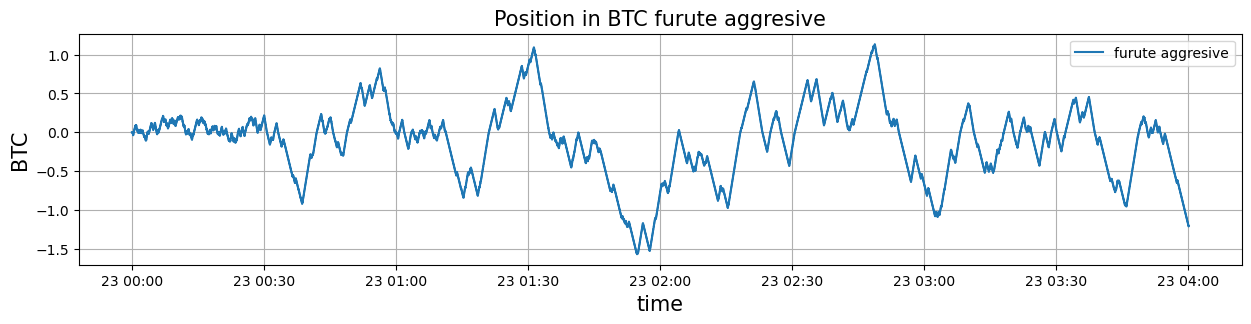

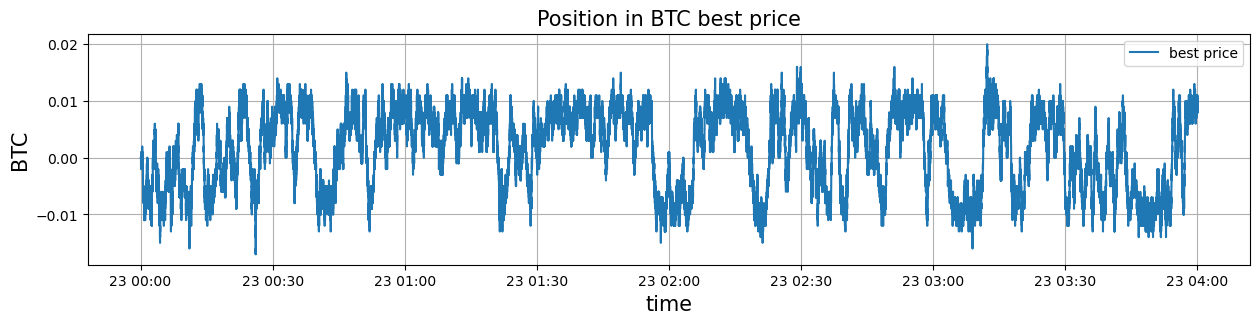

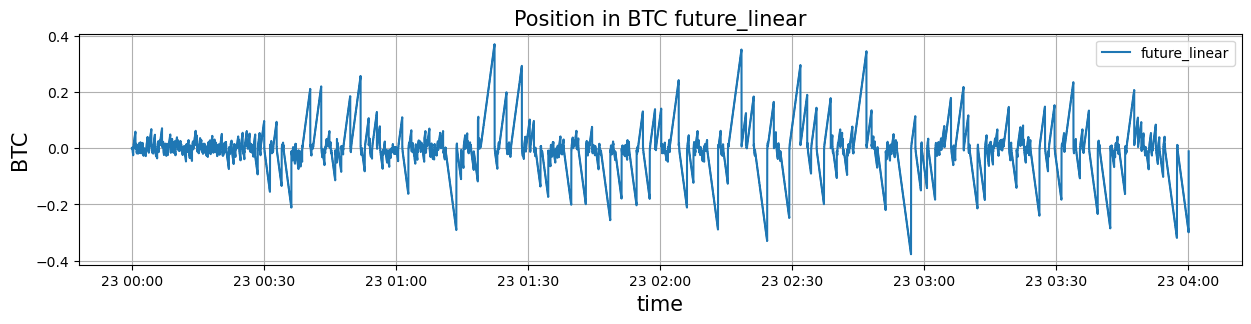

In [15]:
for k, df in dfs.items():
    plt.figure(figsize=(15, 3))
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.BTC, label=k)
    plt.legend()
    plt.title("Position in BTC " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

Стратегия стоикова(после правильного скейлинга инвентори) хорошо ликвидирует позицию, график её инвентори похож на график best_price стратегии с агресивной политикой ликвидации.

Исправил future_price, теперь берётся время через секунду вперёд. Теперь стратегии на основе future_price зарабатывают. future стратегия не учитывает inventory и видно, что у неё максимальный inventory. в future_inv ведётся 'агрессивная' ликвидация позиции: если выходим за пределы q_0, то делаем несимметричные позы на покупку/продажу. Видно, что такая ликвидация не очень хорошо работает: стратегия всё равно набирает большие позиции. стратегия future_linear использует другую стратегию ликвидации, видно, что она работает лучше.

В общем, видно, что future_price стратегии работают лучше.
Из стратегий ликвидации лучше всего работает линейная, график позиций для этой стратегии изображен ниже.

In [16]:
def get_pos(inv):
    ask_pos = 1.0
    
    ask_pos = 1.0
    if inv > q0:
        ask_pos = 1 + inv - q0
    elif inv < -q0:
        ask_pos = 1 + inv + q0
    ask_pos = max(ask_pos, 0.0)

    bid_pos = 1.0
    if inv > q0:
        bid_pos = 1 - (inv - q0)
    elif inv < -q0:
        bid_pos = 1 - (inv + q0)
    bid_pos = max(bid_pos, 0.0)
    
    return ask_pos, bid_pos

In [17]:
inventory = np.linspace(-20, 20, 100)

ask_pos = [get_pos(inv)[0] for inv in inventory]
bid_pos = [get_pos(inv)[1] for inv in inventory]

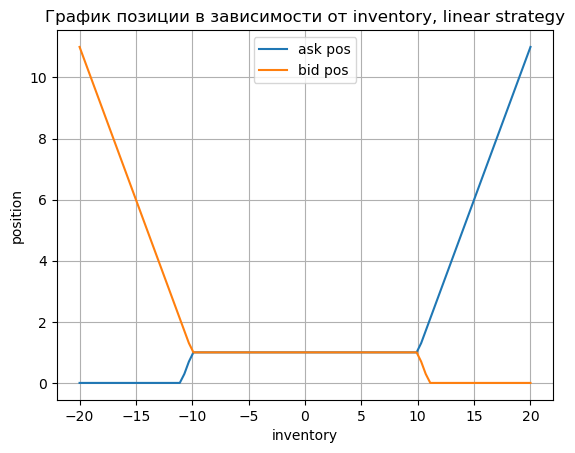

In [18]:
plt.title("График позиции в зависимости от inventory, linear strategy")
plt.plot(inventory, ask_pos, label='ask pos')
plt.plot(inventory, bid_pos, label='bid pos')
plt.grid()
plt.legend()
plt.xlabel("inventory")
plt.ylabel("position")
plt.show()

In [19]:
inventory = np.linspace(-20, 20, 100)

ask_pos = [1.0 + (inv > q0) for inv in inventory]
bid_pos = [1.0 + (inv < -q0) for inv in inventory]

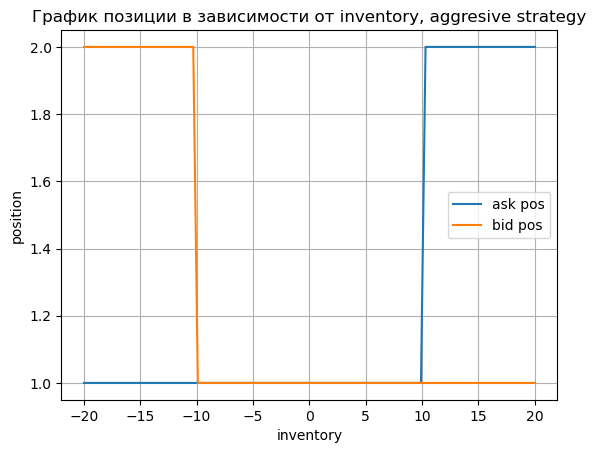

In [20]:
plt.title("График позиции в зависимости от inventory, aggresive strategy")
plt.plot(inventory, ask_pos, label='ask pos')
plt.plot(inventory, bid_pos, label='bid pos')
plt.grid()
plt.legend()
plt.xlabel("inventory")
plt.ylabel("position")
plt.show()